In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import sys
sys.path.append('../') 
from myFunc import predictAccProba, calculateWeight, printEnsembleAccuracy, printCM

In [2]:
#Get cleaned data
df = pd.read_csv("../data/cleanedData.csv")

In [3]:
#Separating the different types of feature
xText = df['fullContent']
xBinary = csr_matrix(df[['urls', 'generalConsumer', 'govDomain', 'eduDomain', 'orgDomain', 'netDomain', 'otherDomain', 'html']].values)
xCont = df[['punctuationCount', 'subjectLength', 'bodyLength', 'totalLength']]
y = df['label']

In [4]:
#train test split data to (train: 80%, test: 20%)
X_train_text, X_test_text, X_train_bin, X_test_bin, X_train_cont, X_test_cont, Y_train, Y_test = train_test_split(
    xText, xBinary, xCont, y, test_size = 0.2, random_state=1
)

In [5]:
#Vectorize text data into numerical values
tfidf = TfidfVectorizer()
X_train_text_tfidf = tfidf.fit_transform(X_train_text)
X_test_text_tfidf = tfidf.transform(X_test_text)

In [6]:
#Scaling the continuous data with varying ranges in wordcounts of email to a range from 0 to 1
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train_cont)
X_test_cont_scaled = scaler.transform(X_test_cont)

In [7]:
#mapping data into dictionary
data = {
    'trainText': X_train_text_tfidf,
    'trainBinary': X_train_bin,
    'trainContinuous': X_train_cont_scaled,
    'trainLabel': Y_train,
    'testText': X_test_text_tfidf,
    'testBinary': X_test_bin,
    'testContinuous': X_test_cont_scaled,
    'testLabel': Y_test
} 

In [8]:
#create base models of multinomial naive bayes, bernoulli naive bayes and gaussian naive bayes with default hyperparameters
baseM = MultinomialNB()
baseB = BernoulliNB()
baseG = GaussianNB()
#fit the different type of training data respective to the models that work best with
#text data => multinomial
#binary features => bernoulli
#continuous features => gaussian
baseM.fit(data['trainText'], data['trainLabel'])
baseB.fit(data['trainBinary'], data['trainLabel'])
baseG.fit(data['trainContinuous'], data['trainLabel'])

GaussianNB()

In [9]:
defaultAcc, defaultProba = predictAccProba(baseM, baseB, baseG, data)

In [10]:
weightedPrediction = printEnsembleAccuracy(calculateWeight(defaultAcc), defaultProba, data['testLabel'])

Multinomial Accuracy: 96.85%
Bernoulli Accuracy: 61.06%
Gaussian Accuracy: 63.58%

Weight for Multinomial: 0.44
Weight for Bernoulli: 0.28
Weight for Gaussian: 0.29
Naive Bayes Ensemble Accuracy: 97.41%


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4210
           1       0.99      0.96      0.98      4648

    accuracy                           0.97      8858
   macro avg       0.97      0.97      0.97      8858
weighted avg       0.97      0.97      0.97      8858



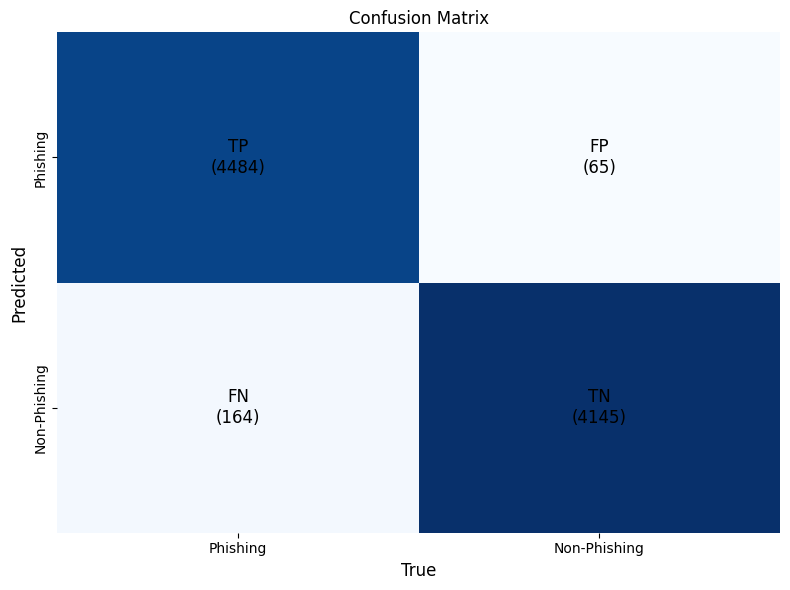

In [11]:
printCM(weightedPrediction, data['testLabel'])

In [12]:
#Setting up parameter grid for the gridsearch
paramGridM = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'fit_prior': [True, False]
}

paramGridB = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'fit_prior': [True, False]
}

paramGridG = {
    'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3]
}

In [13]:
#creating gridsearch with respect of the various hyperparameter combinations in the grid for each of the 3 models
gridSearchM = GridSearchCV(MultinomialNB(), paramGridM, scoring='accuracy', cv=5)
gridSearchB = GridSearchCV(BernoulliNB(), paramGridB, scoring='accuracy', cv=5)
gridSearchG = GridSearchCV(GaussianNB(), paramGridG, scoring='accuracy', cv=5)

gridSearchM.fit(data['trainText'], data['trainLabel'])
gridSearchB.fit(data['trainBinary'], data['trainLabel'])
gridSearchG.fit(data['trainContinuous'], data['trainLabel'])

#Returns the model with the best hyperparameter settings
bestM = gridSearchM.best_estimator_
bestB = gridSearchB.best_estimator_
bestG = gridSearchG.best_estimator_

print(bestM)
print(bestB)
print(bestG)

MultinomialNB(alpha=0.001)
BernoulliNB(alpha=0.001)
GaussianNB(var_smoothing=1e-12)


In [14]:
bestAcc, bestProba = predictAccProba(bestM, bestB, bestG, data)

In [15]:
bestWeightedPrediction = printEnsembleAccuracy(calculateWeight(bestAcc), bestProba, data['testLabel'])

Multinomial Accuracy: 98.40%
Bernoulli Accuracy: 61.06%
Gaussian Accuracy: 63.58%

Weight for Multinomial: 0.44
Weight for Bernoulli: 0.27
Weight for Gaussian: 0.29
Naive Bayes Ensemble Accuracy: 98.78%


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4210
           1       1.00      0.98      0.99      4648

    accuracy                           0.99      8858
   macro avg       0.99      0.99      0.99      8858
weighted avg       0.99      0.99      0.99      8858



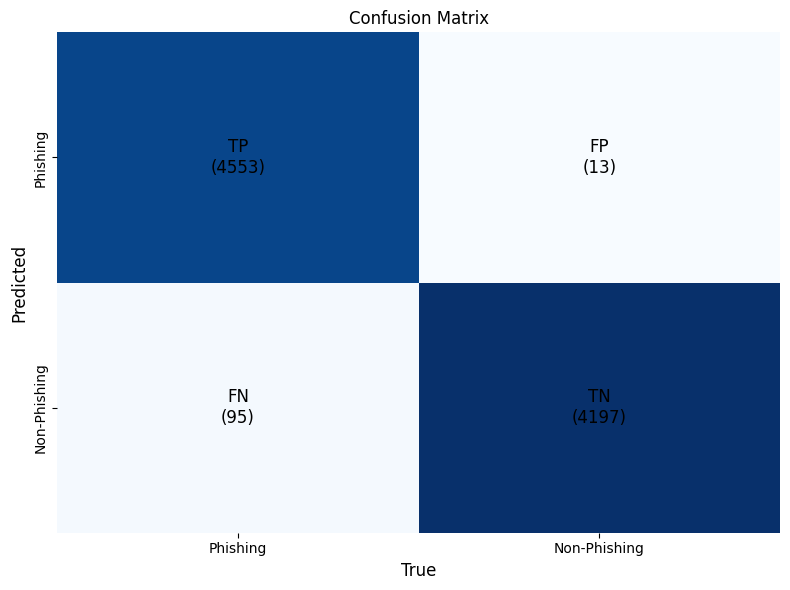

In [16]:
printCM(bestWeightedPrediction, data['testLabel'])

In [17]:
#Saving the tuned models that were already fitted with training data
with open('../model/multinomialNB_zixu.pkl', 'wb') as file: pickle.dump(bestM, file)
with open('../model/bernoulliNB_zixu.pkl', 'wb') as file: pickle.dump(bestB, file)
with open('../model/gaussianNB_zixu.pkl', 'wb') as file: pickle.dump(bestG, file)
